In [1]:

from pathlib import Path
import sys

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import FancyArrowPatch
from shapely.geometry import LineString

# Ensure project root (where scripts live) is on the import path
PROJECT_ROOT_CANDIDATE = Path.cwd
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import FancyArrowPatch
from shapely.geometry import LineString

# Ensure project root (where scripts live) is on the import path
PROJECT_ROOT_CANDIDATE = Path.cwd()
if not (PROJECT_ROOT_CANDIDATE / "sent_si.py").exists():
    PROJECT_ROOT_CANDIDATE = PROJECT_ROOT_CANDIDATE.parent
if str(PROJECT_ROOT_CANDIDATE) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT_CANDIDATE))

from sent_si import read_network_data

plt.rcParams["figure.dpi"] = 120
()
if not (PROJECT_ROOT_CANDIDATE / "sent_si.py").exists():
    PROJECT_ROOT_CANDIDATE = PROJECT_ROOT_CANDIDATE.parent
if str(PROJECT_ROOT_CANDIDATE) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT_CANDIDATE))

from sent_si import read_network_data

plt.rcParams["figure.dpi"] = 120


In [2]:
## Load in rank table
## Load in first, top ranking node
## Plot top ranking node on New Zealand map
## Draw arrows where it is connecting to
## Shade arrows based on strenght of the weights

In [3]:
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "sent_si.py").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_ROOT = PROJECT_ROOT

RANK_TABLE_PATH = DATA_ROOT / "notebook" / "sentinel_rank_table.csv"
PROPERTY_PATH = DATA_ROOT / "params" / "2024_prop_dat.csv"
REGION_SHAPE_PATH = DATA_ROOT / "params" / "regional-council-2025-clipped.shp"
SEED_DATA_PATH = DATA_ROOT / "data" / "data_y_real.csv"

TOP_FRACTIONS = {"p01": 0.01, "p10": 0.10}

rank_table = pd.read_csv(RANK_TABLE_PATH)
rank_table["sent"] = pd.to_numeric(rank_table["sent"], errors="coerce")
rank_table = rank_table.dropna(subset=["sent"]).copy()
rank_table["sent"] = rank_table["sent"].astype(int)

properties = pd.read_csv(PROPERTY_PATH)
properties = properties.rename(
    columns={
        "GPS_CENTRE_LATITUDE": "longitude",
        "GPS_CENTRE_LONGITUDE": "latitude",
    }
)
properties_coords = (
    properties[["PROPERTY_ID", "latitude", "longitude"]]
    .dropna(subset=["latitude", "longitude"])
    .drop_duplicates(subset=["PROPERTY_ID"])
)
properties_coords["PROPERTY_ID"] = pd.to_numeric(properties_coords["PROPERTY_ID"], errors="coerce")
properties_coords = properties_coords.dropna(subset=["PROPERTY_ID"]).copy()
properties_coords["PROPERTY_ID"] = properties_coords["PROPERTY_ID"].astype(int)

coords_lookup = properties_coords.set_index("PROPERTY_ID")[
    ["latitude", "longitude"]
].to_dict("index")

seed_ids = pd.read_csv(SEED_DATA_PATH, usecols=["seed"])["seed"]
seed_ids = pd.to_numeric(seed_ids, errors="coerce").dropna().astype(int)
seed_coords = properties_coords[properties_coords["PROPERTY_ID"].isin(seed_ids)].copy()
seed_points = gpd.GeoDataFrame(
    seed_coords,
    geometry=gpd.points_from_xy(seed_coords["longitude"], seed_coords["latitude"]),
    crs="EPSG:4326",
)

nz_regions = gpd.read_file(REGION_SHAPE_PATH)
if nz_regions.crs is None:
    nz_regions = nz_regions.set_crs(epsg=4326, allow_override=True)
elif getattr(nz_regions.crs, "to_epsg", lambda: None)() != 4326:
    nz_regions = nz_regions.to_crs(epsg=4326)

rank_summary = (
    rank_table
    .rename(columns={"sent": "PROPERTY_ID"})
    .drop_duplicates(subset=["PROPERTY_ID"])
    .merge(properties_coords, on="PROPERTY_ID", how="left")
)
rank_summary[["R_F", "d"]] = rank_summary[["R_F", "d"]].apply(pd.to_numeric, errors="coerce")

centrality_df = rank_summary[["PROPERTY_ID", "latitude", "longitude", "d"]].dropna().copy()

size_map = {}
for key, frac in TOP_FRACTIONS.items():
    size_map[key] = {
        "ranking": max(1, int(len(rank_summary) * frac + 0.5)),
        "centrality": max(1, int(len(centrality_df) * frac + 0.5)),
    }

lon_bounds = (166.0, 179.0)
lat_bounds = (-47.5, -33.5)

print(f"Working with {len(rank_summary)} sentinel nodes.")
for key, sizes in size_map.items():
    pct = float(key[1:]) / 100
    print(
        f"Top {sizes['centrality']} (~{pct:.1%}) degree nodes and top {sizes['ranking']} R_F nodes will be shown for subset {key}."
    )

rf_top = {}
degree_top = {}
for key, sizes in size_map.items():
    rf_top[key] = (
        rank_summary[["PROPERTY_ID", "latitude", "longitude", "R_F"]]
        .sort_values("R_F", ascending=True)
        .head(sizes["ranking"])
        .copy()
    )
    degree_top[key] = (
        centrality_df
        .sort_values("d", ascending=False)
        .head(sizes["centrality"])
        .copy()
    )

NETWORK_PATH = DATA_ROOT / "params" / "hort365_NZ.csv"


def _safe_int(value):
    try:
        return int(float(value))
    except (TypeError, ValueError):
        return None


in_bound_raw, out_bound_raw = read_network_data(NETWORK_PATH)

in_bound = {}
for node_key, neighbours in in_bound_raw.items():
    node_id = _safe_int(node_key)
    if node_id is None:
        continue
    converted = {}
    for neighbour_key, weight in neighbours.items():
        neighbour_id = _safe_int(neighbour_key)
        if neighbour_id is None:
            continue
        try:
            converted[neighbour_id] = float(weight)
        except (TypeError, ValueError):
            continue
    if converted:
        in_bound[node_id] = converted

out_bound = {}
for node_key, neighbours in out_bound_raw.items():
    node_id = _safe_int(node_key)
    if node_id is None:
        continue
    converted = {}
    for neighbour_key, weight in neighbours.items():
        neighbour_id = _safe_int(neighbour_key)
        if neighbour_id is None:
            continue
        try:
            converted[neighbour_id] = float(weight)
        except (TypeError, ValueError):
            continue
    if converted:
        out_bound[node_id] = converted

rank_with_coords = rank_summary.dropna(subset=["latitude", "longitude", "R_F"]).copy()


def _empty_edge_gdf():
    return gpd.GeoDataFrame(
        {
            "source": pd.Series(dtype=int),
            "dest": pd.Series(dtype=int),
            "weight": pd.Series(dtype=float),
            "direction": pd.Series(dtype=object),
        },
        geometry=gpd.GeoSeries([], dtype="geometry"),
        crs="EPSG:4326",
    )


def _empty_point_gdf():
    return gpd.GeoDataFrame(
        {
            "node": pd.Series(dtype=int),
            "longitude": pd.Series(dtype=float),
            "latitude": pd.Series(dtype=float),
            "direction": pd.Series(dtype=object),
        },
        geometry=gpd.GeoSeries([], dtype="geometry"),
        crs="EPSG:4326",
    )


def _build_points_from_ids(node_ids, direction_label):
    records = []
    for node_id in sorted(set(node_ids)):
        coords = coords_lookup.get(node_id)
        if not coords:
            continue
        records.append(
            {
                "node": node_id,
                "longitude": coords["longitude"],
                "latitude": coords["latitude"],
                "direction": direction_label,
            }
        )
    if not records:
        return _empty_point_gdf()
    df = pd.DataFrame(records)
    return gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
        crs="EPSG:4326",
    )

if rank_with_coords.empty:
    top_rf_row = None
    top_rf_node_id = None
    top_rf_node_coords = None
    top_rf_out_edges_gdf = _empty_edge_gdf()
    top_rf_in_edges_gdf = _empty_edge_gdf()
    top_rf_edges_gdf = _empty_edge_gdf()
    top_rf_out_points = _empty_point_gdf()
    top_rf_in_points = _empty_point_gdf()
    top_rf_in_support_points = _empty_point_gdf()
    top_rf_out_support_points = _empty_point_gdf()
else:
    top_rf_row = rank_with_coords.sort_values("R_F", ascending=True).iloc[0]
    top_rf_node_id = int(top_rf_row["PROPERTY_ID"])
    top_rf_node_coords = {
        "longitude": float(top_rf_row["longitude"]),
        "latitude": float(top_rf_row["latitude"]),
        "R_F": float(top_rf_row["R_F"]),
    }

    inbound_neighbors = list(in_bound.get(top_rf_node_id, {}).keys())
    outbound_neighbors = list(out_bound.get(top_rf_node_id, {}).keys())

    inbound_records = []
    inbound_geometries = []
    for src_id in inbound_neighbors:
        src_coords = coords_lookup.get(src_id)
        if not src_coords:
            continue
        weight = in_bound[top_rf_node_id][src_id]
        inbound_records.append(
            {
                "source": src_id,
                "dest": top_rf_node_id,
                "weight": float(weight),
                "direction": "inbound",
            }
        )
        inbound_geometries.append(
            LineString(
                [
                    (src_coords["longitude"], src_coords["latitude"]),
                    (top_rf_node_coords["longitude"], top_rf_node_coords["latitude"]),
                ]
            )
        )

    outbound_records = []
    outbound_geometries = []
    for dest_id in outbound_neighbors:
        dest_coords = coords_lookup.get(dest_id)
        if not dest_coords:
            continue
        weight = out_bound[top_rf_node_id][dest_id]
        outbound_records.append(
            {
                "source": top_rf_node_id,
                "dest": dest_id,
                "weight": float(weight),
                "direction": "outbound",
            }
        )
        outbound_geometries.append(
            LineString(
                [
                    (top_rf_node_coords["longitude"], top_rf_node_coords["latitude"]),
                    (dest_coords["longitude"], dest_coords["latitude"]),
                ]
            )
        )

    top_rf_in_edges_gdf = (
        gpd.GeoDataFrame(inbound_records, geometry=inbound_geometries, crs="EPSG:4326")
        if inbound_records
        else _empty_edge_gdf()
    )
    top_rf_out_edges_gdf = (
        gpd.GeoDataFrame(outbound_records, geometry=outbound_geometries, crs="EPSG:4326")
        if outbound_records
        else _empty_edge_gdf()
    )

    top_rf_in_points = _build_points_from_ids(inbound_neighbors, "inbound")
    top_rf_out_points = _build_points_from_ids(outbound_neighbors, "outbound")

    edge_frames = [df for df in (top_rf_out_edges_gdf, top_rf_in_edges_gdf) if not df.empty]
    if len(edge_frames) == 1:
        top_rf_edges_gdf = edge_frames[0].copy()
    elif edge_frames:
        top_rf_edges_gdf = gpd.GeoDataFrame(
            pd.concat(edge_frames, ignore_index=True),
            geometry="geometry",
            crs="EPSG:4326",
        )
    else:
        top_rf_edges_gdf = _empty_edge_gdf()

    inbound_support_ids = set()
    for neighbor_id in inbound_neighbors:
        inbound_support_ids.update(in_bound.get(neighbor_id, {}).keys())
    inbound_support_ids.discard(top_rf_node_id)
    inbound_support_ids -= set(inbound_neighbors)
    top_rf_in_support_points = _build_points_from_ids(inbound_support_ids, "inbound_support")

    outbound_support_ids = set()
    for neighbor_id in outbound_neighbors:
        outbound_support_ids.update(out_bound.get(neighbor_id, {}).keys())
    outbound_support_ids.discard(top_rf_node_id)
    outbound_support_ids -= set(outbound_neighbors)
    top_rf_out_support_points = _build_points_from_ids(outbound_support_ids, "outbound_support")

    inbound_count = len(inbound_neighbors)
    outbound_count = len(outbound_neighbors)
    inbound_support_count = len(top_rf_in_support_points)
    outbound_support_count = len(top_rf_out_support_points)

    print(
        f"Top $R_F$ node {top_rf_node_id} with R_F={top_rf_node_coords['R_F']:.0f} has "
        f"{outbound_count} outbound and {inbound_count} inbound connections with coordinates."
    )
    if inbound_support_count or outbound_support_count:
        print(
            f"Highlighting {inbound_support_count} inbound support nodes and "
            f"{outbound_support_count} outbound support nodes."
        )


Working with 1503 sentinel nodes.
Top 15 (~1.0%) degree nodes and top 15 R_F nodes will be shown for subset p01.
Top 150 (~10.0%) degree nodes and top 150 R_F nodes will be shown for subset p10.
Top $R_F$ node 8515 with R_F=1 has 3 outbound and 3 inbound connections with coordinates.
Highlighting 51 inbound support nodes and 20 outbound support nodes.


In [4]:

def plot_rf_best(subset_key, cmap="viridis"):
    subset = rf_top[subset_key].copy()
    subset["rank_position"] = np.arange(1, len(subset) + 1)

    if subset.empty:
        print(f"No data available for degree top nodes ({subset_key}).")
        return

    fig, ax = plt.subplots(figsize=(8.5, 13))
    fig.patch.set_facecolor("white")

    nz_regions.plot(ax=ax, color="#fbfbfb", edgecolor="#606060", linewidth=0.6, zorder=0)
    if not seed_points.empty:
        seed_points.plot(ax=ax, color="#9db5ad", alpha=0.22, markersize=6, zorder=1)

    scatter = ax.scatter(
        subset["longitude"],
        subset["latitude"],
        s=45,
        c=subset["rank_position"],
        cmap=cmap,
        edgecolor="#1f1f1f",
        linewidth=0.7,
        zorder=2,
    )

    ax.set_xlim(lon_bounds)
    ax.set_ylim(lat_bounds)
    ax.set_aspect("equal", adjustable="box")
    title_suffix = "(top 1%)" if subset_key == "p01" else "(top 10%)"
    ax.set_title(f"$R_F$ Nodes {title_suffix}", fontsize=15, fontweight="bold", pad=18)
    ax.set_axis_off()

    cbar = fig.colorbar(scatter, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label(f"$R_F$ rank (1 = highest)")

    handles = []
    if not seed_points.empty:
        handles.append(Line2D([], [], marker="o", linestyle="", markersize=6, markerfacecolor="#9db5ad", markeredgewidth=0, alpha=0.6, label="Seed nodes"))
    handles.append(Line2D([], [], marker="o", linestyle="", markersize=6, markerfacecolor="#3f007d", markeredgecolor="#1f1f1f", label="Top degree"))
    ax.legend(handles=handles, loc="lower left", frameon=True)

    plt.show()


def plot_top_rf_connections():
    if top_rf_node_coords is None or top_rf_edges_gdf.empty:
        print("No connection data available for the top $R_F$ node.")
        return

    fig, ax = plt.subplots(figsize=(8.5, 13))
    fig.patch.set_facecolor("white")

    nz_regions.plot(ax=ax, color="#fbfbfb", edgecolor="#606060", linewidth=0.6, zorder=0)

    if not seed_points.empty:
        seed_points.plot(ax=ax, color="#9db5ad", alpha=0.22, markersize=6, zorder=1)

    if not top_rf_in_support_points.empty:
        top_rf_in_support_points.plot(ax=ax, color="#9ecae1", markersize=22, alpha=0.8, zorder=3, label="Inbound support nodes")
    if not top_rf_out_support_points.empty:
        top_rf_out_support_points.plot(ax=ax, color="#8c8c8c", markersize=22, alpha=0.8, zorder=3, label="Outbound support nodes")

    if not top_rf_out_points.empty:
        top_rf_out_points.plot(ax=ax, color="#252525", markersize=56, alpha=0.85, zorder=4, label="Outbound neighbours")
    if not top_rf_in_points.empty:
        top_rf_in_points.plot(ax=ax, color="#08519c", markersize=56, alpha=0.85, zorder=4, label="Inbound neighbours")

    for _, row in top_rf_edges_gdf.iterrows():
        xs, ys = row.geometry.xy
        if row["direction"] == "outbound":
            color = "#252525"
            linestyle = "-"
        else:
            color = "#08519c"
            linestyle = "--"
        ax.plot(xs, ys, color=color, linewidth=2.4, alpha=0.95, zorder=3.5, linestyle=linestyle)
        if len(xs) >= 2:
            arrow = FancyArrowPatch(
                (xs[-2], ys[-2]),
                (xs[-1], ys[-1]),
                arrowstyle="-|>",
                mutation_scale=18,
                color=color,
                linewidth=0,
                alpha=0.95,
                zorder=4,
                shrinkA=0,
                shrinkB=0,
            )
            ax.add_patch(arrow)

    ax.scatter(
        [top_rf_node_coords["longitude"]],
        [top_rf_node_coords["latitude"]],
        s=95,
        marker="*",
        color="#023858",
        edgecolor="#fefefe",
        linewidth=1.1,
        zorder=5,
        label="Top $R_F$ node",
    )

    ax.set_xlim(lon_bounds)
    ax.set_ylim(lat_bounds)
    ax.set_aspect("equal", adjustable="box")
    ax.set_axis_off()
    ax.set_title(
        f"Top $R_F$ node {top_rf_node_id} inbound/outbound network",
        fontsize=15,
        fontweight="bold",
        pad=18,
    )

    handles = [Line2D([], [], marker="*", linestyle="", markersize=10, markerfacecolor="#023858", markeredgecolor="#fefefe", label="Top $R_F$ node")]
    if not seed_points.empty:
        handles.append(Line2D([], [], marker="o", linestyle="", markersize=6, markerfacecolor="#9db5ad", markeredgewidth=0, alpha=0.6, label="Seed nodes"))
    if not top_rf_in_points.empty:
        handles.append(Line2D([], [], marker="o", linestyle="", markersize=6, markerfacecolor="#08519c", markeredgewidth=0, label="Inbound neighbours"))
    if not top_rf_out_points.empty:
        handles.append(Line2D([], [], marker="o", linestyle="", markersize=6, markerfacecolor="#252525", markeredgecolor="#252525", label="Outbound neighbours"))
    if not top_rf_in_support_points.empty:
        handles.append(Line2D([], [], marker="o", linestyle="", markersize=6, markerfacecolor="#9ecae1", markeredgewidth=0, label="Inbound support nodes"))
    if not top_rf_out_support_points.empty:
        handles.append(Line2D([], [], marker="o", linestyle="", markersize=6, markerfacecolor="#8c8c8c", markeredgecolor="#8c8c8c", label="Outbound support nodes"))
    if not top_rf_in_edges_gdf.empty:
        handles.append(Line2D([], [], color="#08519c", linewidth=2.4, linestyle="--", label="Inbound link"))
    if not top_rf_out_edges_gdf.empty:
        handles.append(Line2D([], [], color="#252525", linewidth=2.4, linestyle="-", label="Outbound link"))
    ax.legend(handles=handles, loc="lower left", frameon=True)

    plt.show()


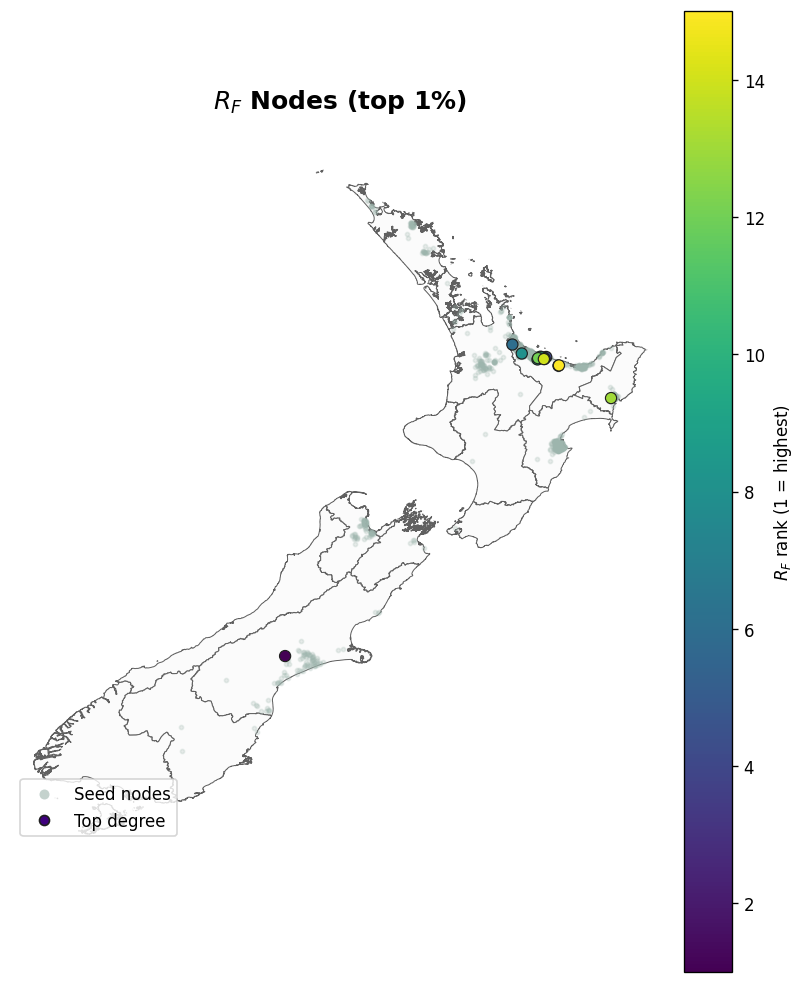

In [5]:

# Top 1%
plot_rf_best("p01")


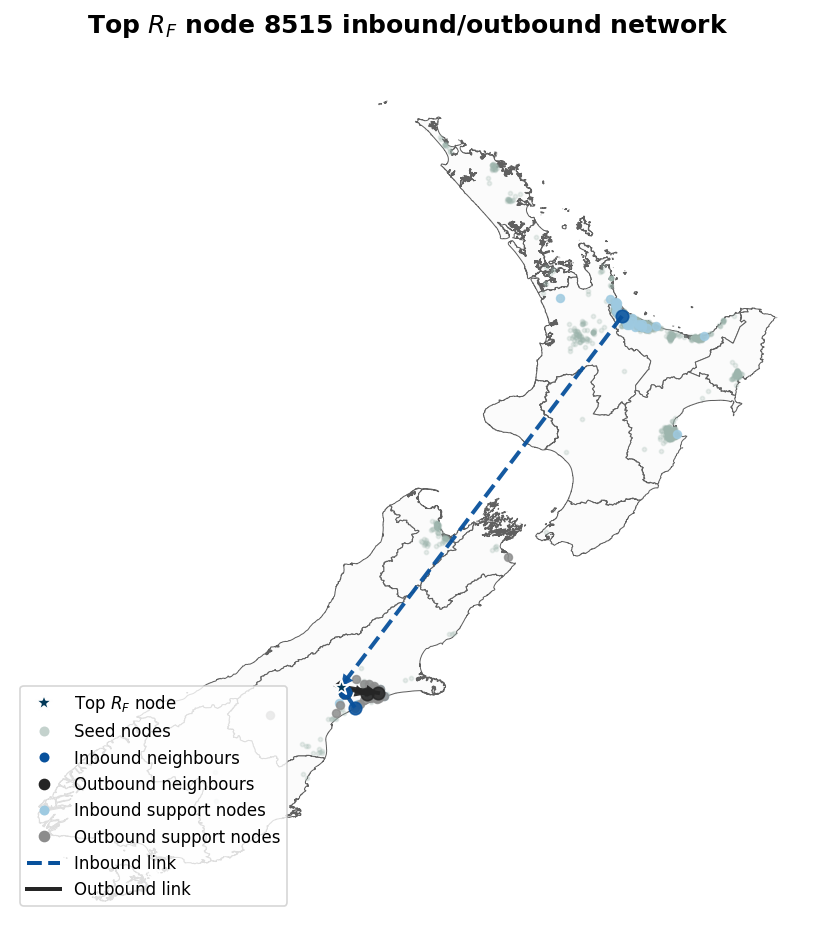

In [6]:

plot_top_rf_connections()


In [7]:
### in-component? modularity? 